Questions to look into:
- What is the effect of price on a conversion rate, any pattern we can observe?
- Are two products similar in their performance?
- What data would you wish to have for better evaluating the effect and why?

## Import libraries

In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

## Functions

In [202]:
# Function to plot the learning curve
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [203]:
# Function to calculate MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [204]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [205]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

### Import Dataset

In [206]:
df = pd.read_csv('data.csv')

### Variable inspection and meaning

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3848 non-null   object 
 1   product_id     3848 non-null   object 
 2   nbr_clicks     3848 non-null   int64  
 3   price_buckets  3848 non-null   float64
 4   cr             3848 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 150.4+ KB


- There's two objects: date and product_id. Date needs to be converted into datetime <br> 
- Number of clicks is an integer <br>
- Price Bucket and CR are floats

- product_id: identifier of the product <br>
- nbr_clicks: Number of Clicks <br>
- price_buckets: 5€ price buckets <br>
- CR: Conversion Rate 

In [208]:
df.head()

,date,product_id,nbr_clicks,price_buckets,cr
0,2020-06-01,521732A,1,195.0,0.000000
1,2020-06-01,521732A,35,205.0,0.000000
2,2020-06-01,521732A,240,210.0,0.016667
3,2020-06-01,521732A,1070,215.0,0.013084
4,2020-06-01,521732A,32,230.0,0.031250


Interpretation: On the first of june 2020, the product with the ID '521732A' when it had the price_bucket '190-195' it had just 1 click and the Conversion Rate of 0

In [209]:
df.isna().sum()

date             0
product_id       0
nbr_clicks       0
price_buckets    0
cr               0
dtype: int64

No missing values

## Exploratory Data Analysis

In [210]:
# Function to check if the fractional part is zero
def is_fraction_zero(num):
    return num == int(num)

# Apply the function to the DataFrame column
df['is_fraction_zero'] = df['price_buckets'].apply(is_fraction_zero)

In [211]:
df[df['is_fraction_zero'] == 'False']

,date,product_id,nbr_clicks,price_buckets,cr,is_fraction_zero


There's no price_bucket with a decimal value other than 0, therefore we can convert it into integer

In [212]:
# Drop Column that not longer needs to be used
cols_to_drop = 'is_fraction_zero'
df.drop(columns=cols_to_drop,inplace=True)

## Feature Engineering

In [213]:
# Create Conversions Variable
df['Conversions'] = df['cr'] * df['nbr_clicks']

In [214]:
# Convert Date from object into datetime
df['date'] = pd.to_datetime(df['date'])

In [215]:
# Convert Date from object into datetime
df['price_buckets'] = df['price_buckets'].astype(int)

In [216]:
# Create Week, Year and Month Variables
df['Week'] = df['date'].dt.week.astype(str)
df['Month'] = df['date'].dt.month.astype(str)
df['Year'] = df['date'].dt.year.astype(str)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/1909988502.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['date'].dt.week.astype(str)


In [217]:
# Create binary variable to indicate if there was a conversion or not
df['convert'] = np.where(df['cr'] > 0, 1, 0)

In [218]:
summary=df.describe(include='all')
summary=summary.transpose()
summary

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/2667510349.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary=df.describe(include='all')


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,3848,162,2020-07-01 00:00:00,35,2020-06-01,2020-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,3848,2,167864A,2370,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nbr_clicks,3848.0,NaN,NaN,NaN,NaT,NaT,254.608888,488.835259,1.0,5.0,34.0,271.25,4106.0
price_buckets,3848.0,NaN,NaN,NaN,NaT,NaT,285.33264,61.992466,170.0,230.0,290.0,325.0,720.0
cr,3848.0,NaN,NaN,NaN,NaT,NaT,0.012588,0.03435,0.0,0.0,0.0,0.014782,1.0
Conversions,3848.0,NaN,NaN,NaN,NaT,NaT,3.505717,7.29785,0.0,0.0,0.0,4.0,81.0
Week,3848,24,27,217,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,3848,6,6,756,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3848,1,2020,3848,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
convert,3848.0,NaN,NaN,NaN,NaT,NaT,0.463877,0.498758,0.0,0.0,0.0,1.0,1.0


- The dataset contains data between the 1st of June 2020 until the 9th of November 2020; <br>
- There's two product_ids, the one with more sample data is 167864A; <br>
- Number of clicks ranges between 1 to 4.106, where the mean is 254 clicks and the mean 34. There are outliers in the variable; <br>
- Price Buckets range between 170 to 720, where the mean is 285 - there are also some outliers here; <br>
- Conversion Rate ranges between 0 and 1, where the mean conversion rate is 1,26%; <br>
- The average volume of conversions is 4, but there's dates with no conversions and others with 81 conversions; <br>
- The month with most data is june and week is number 27 
- Convert - mean is 0.46 meaning, that most did not convert

## Outliers Detection

/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

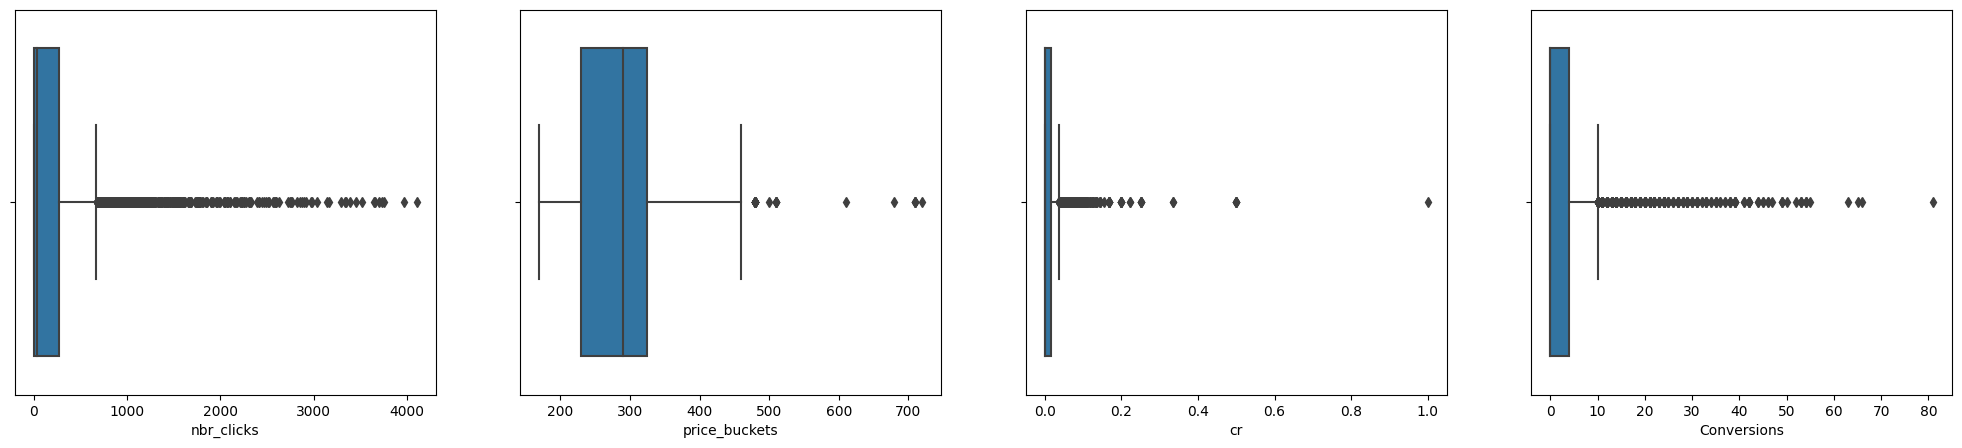

In [219]:
# Do boxplots on all numeric variables
numerical=df.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(1,4, figsize=(25, 5))
for var, subplot in zip(df[numerical], ax.flatten()):
    sns.boxplot(df[var], ax=subplot)

There's outliers in all numerical values

### Histogram for Numerical Variables

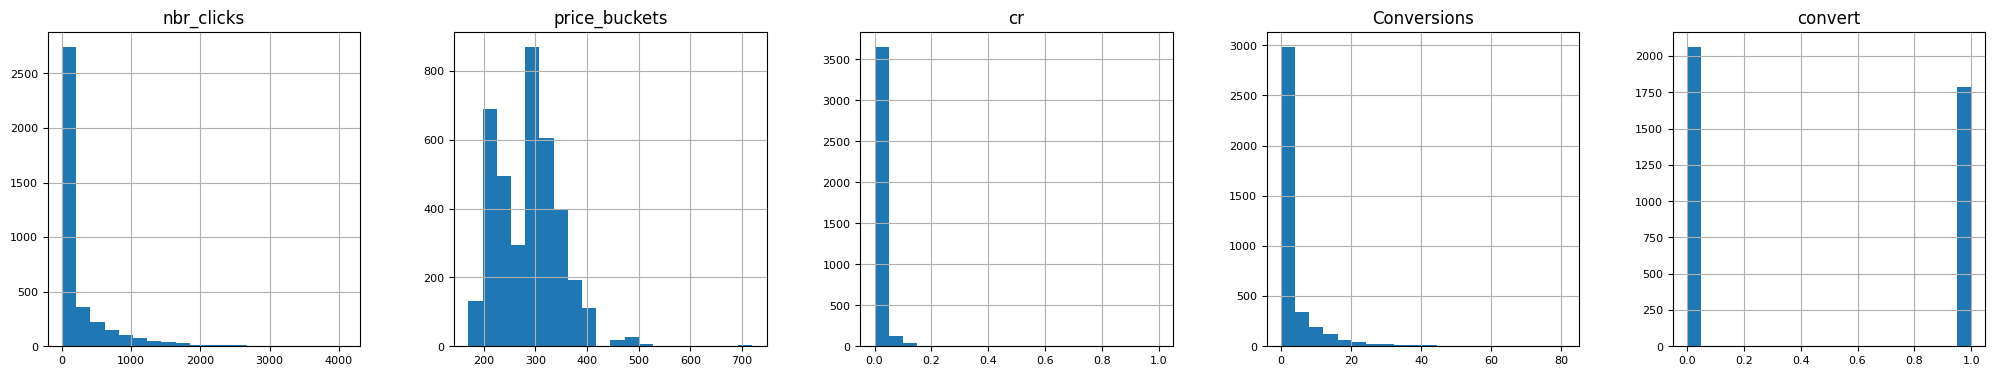

In [220]:
# Do histograms on all numeric variables
numerical=df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical].hist(bins=20, figsize=(25, 20), layout=(4, 5), xlabelsize=8, ylabelsize=8);

Number of clicks are mostly between 0-1000 <br>
Price bucket seems to follow a distribution concentrated between 100 to 500 with some outliers <br>
Conversion Rate is also between 0 to 0.2%, but with some outliers going up to 1 <br>
Conversions are also mostly between 0-20 with some outliers going up to 80

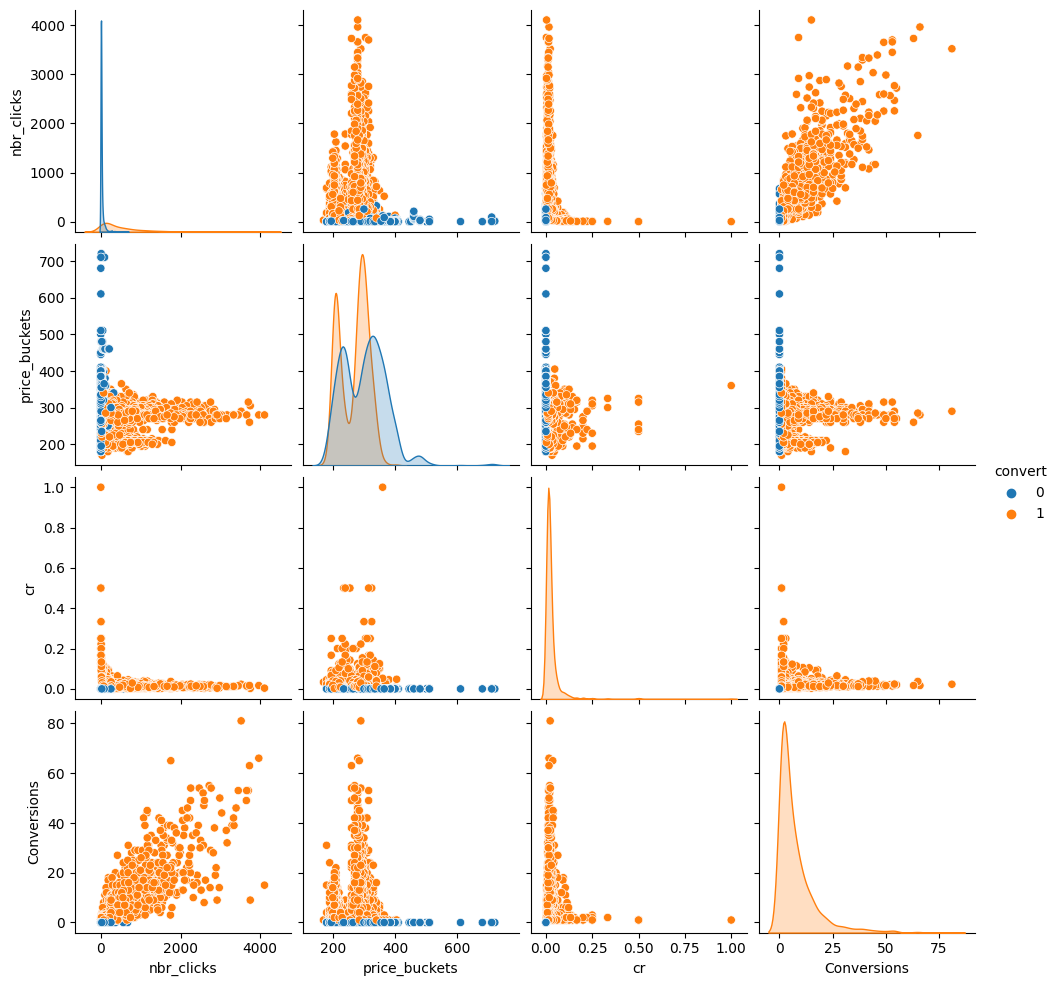

In [221]:
# Create a pair plot
sns.pairplot(df, hue='convert', diag_kind='kde')

# Show the plot
plt.show()

The behaviour of those combination of dates and price buckets where there are conversions seems to have a lot more clicks than when no conversion occurs; <br>
The price bucket for those seems to range only between 0-400, while the other ranges do not convert; <br>

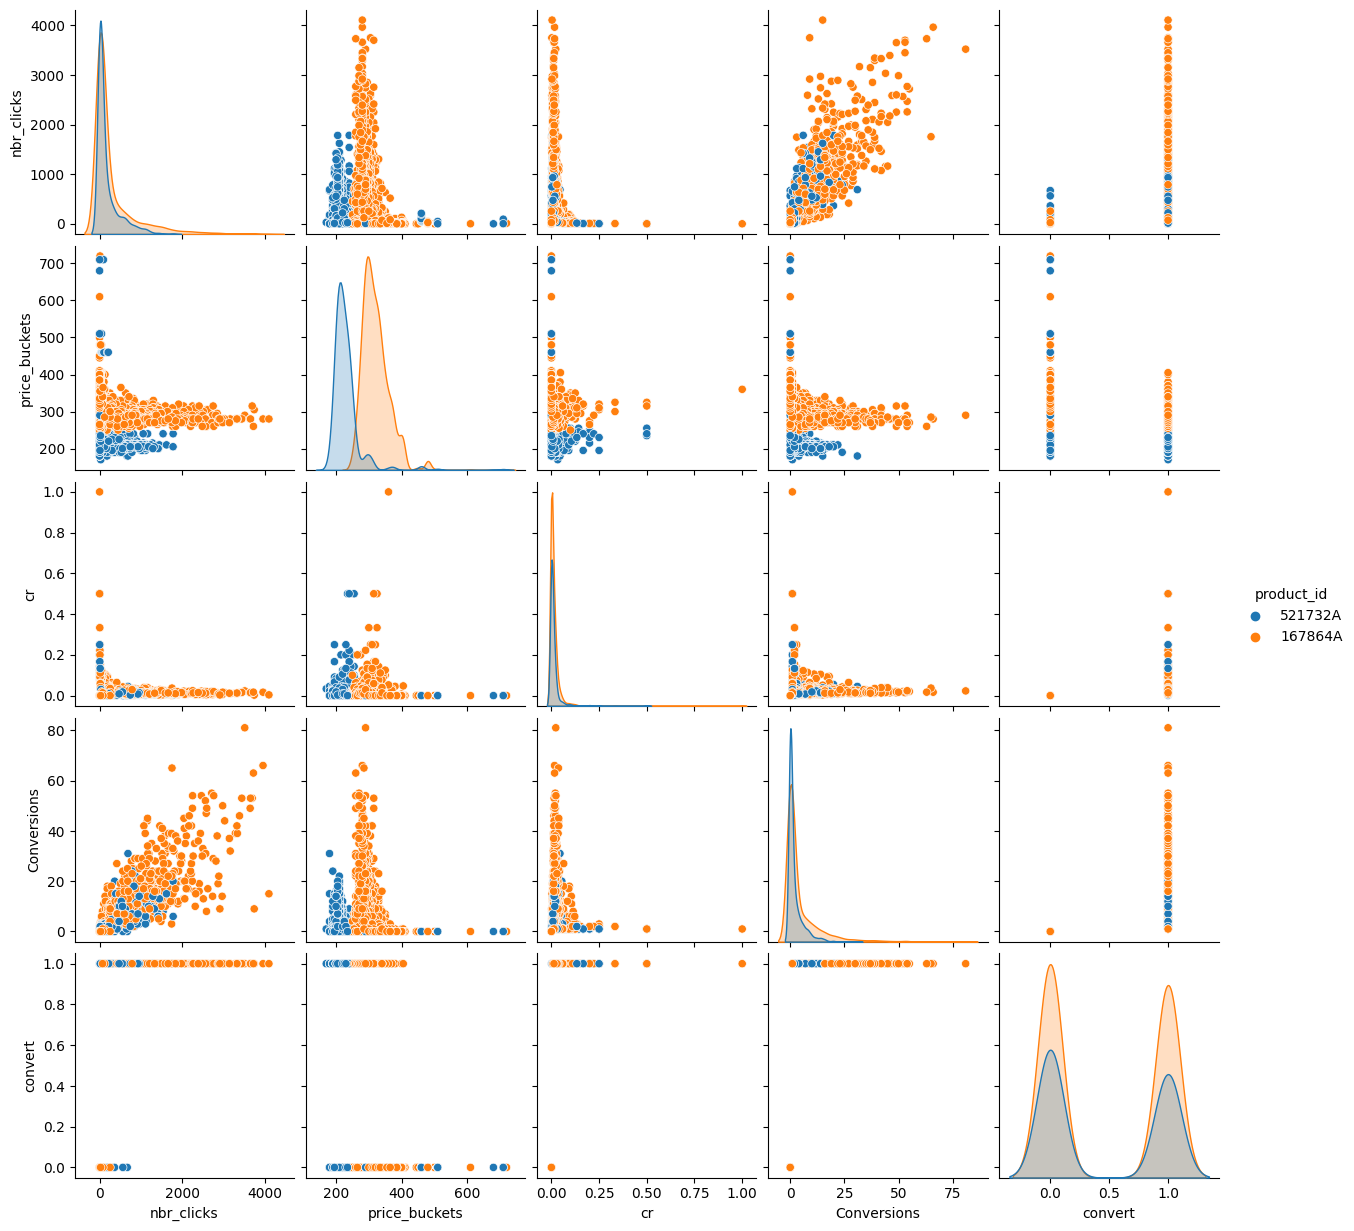

In [222]:
# Create a pair plot
sns.pairplot(df, hue='product_id', diag_kind='kde')

# Show the plot
plt.show()

Product ID 167864A is more right skewed in regards to number of clicks that the other; <br>
The Conversion Rate also looks like to gravitate a lot more, as well as the number of conversions; <br>
Convert seems to be much more present in that product id; <br>
Price Buckets seems to also be more expensive for that product;

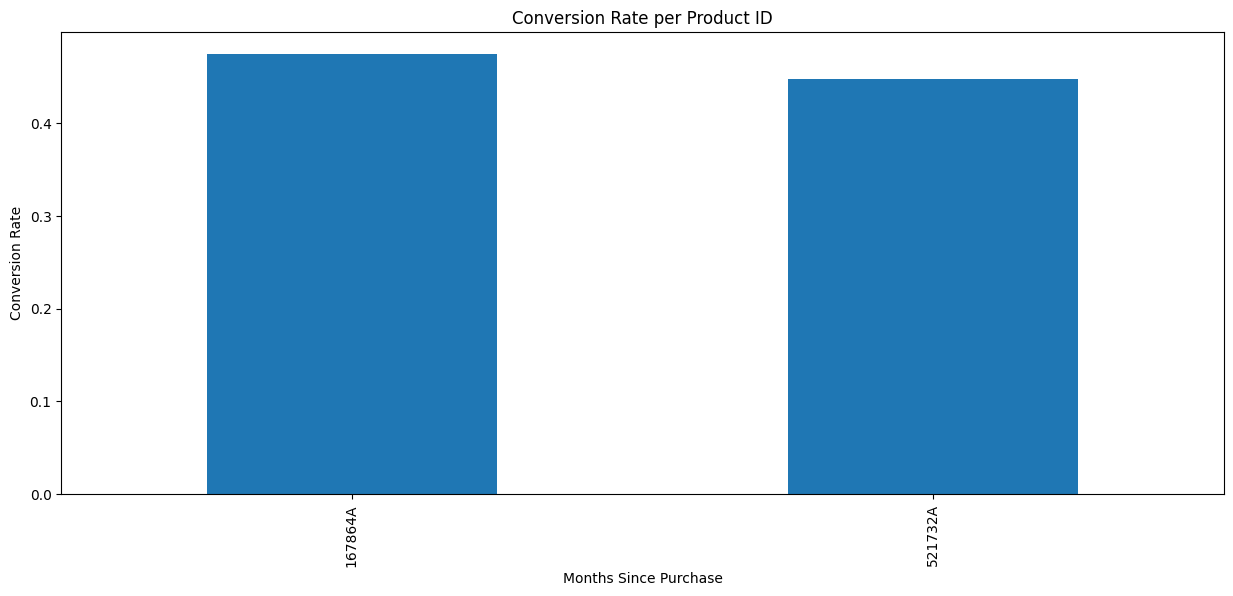

In [223]:
# Group by 'months_since_purchase' and calculate the churn rate
grouped = df.groupby('product_id').agg(
    total_users=pd.NamedAgg(column='convert', aggfunc='size'),
    converted_users=pd.NamedAgg(column='convert', aggfunc='sum')
)
grouped['conversion_rate'] = grouped['converted_users'] / grouped['total_users']

# Plotting
plt.figure(figsize=(15, 6))
grouped['conversion_rate'].plot(kind='bar')
plt.xlabel('Months Since Purchase')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Product ID')
plt.show()

In [224]:
df.tail()

,date,product_id,nbr_clicks,price_buckets,cr,Conversions,Week,Month,Year,convert
3843,2020-11-09,167864A,1,335,0.000000,0.0,46,11,2020,0
3844,2020-11-09,167864A,73,340,0.013699,1.0,46,11,2020,1
3845,2020-11-09,167864A,10,355,0.000000,0.0,46,11,2020,0
3846,2020-11-09,167864A,84,365,0.000000,0.0,46,11,2020,0
3847,2020-11-09,167864A,26,480,0.000000,0.0,46,11,2020,0


In [225]:
plot = pd.pivot_table(df, index=['product_id'], values=['Conversions','nbr_clicks','cr'], aggfunc={'Conversions':'sum','nbr_clicks':'sum','cr':'mean'})

In [226]:
plot.reset_index(inplace=True)

In [227]:
plot

,product_id,Conversions,cr,nbr_clicks
0,167864A,10629.0,0.013188,720008
1,521732A,2861.0,0.011627,259727


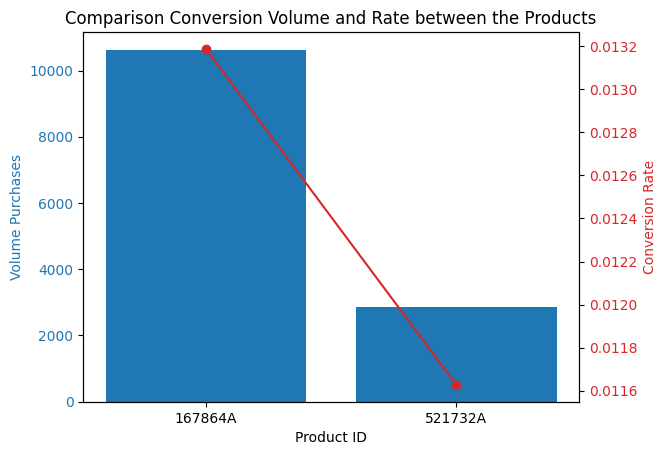

In [228]:
# Now, let's create the plot:
fig, ax1 = plt.subplots()

# Bar chart for Volume Purchases
color = 'tab:blue'
ax1.set_xlabel('Product ID')
ax1.set_ylabel('Volume Purchases', color=color)
ax1.bar(plot['product_id'], plot['Conversions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate the second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Conversion Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(plot['product_id'], plot['cr'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Title of the graph
plt.title('Comparison Conversion Volume and Rate between the Products')

# Show the plot
plt.show()

Fazer plot da CR over time e dos clicks
Ver de que maneira se altera com o preço, se calhar por buckets

In [229]:
plot_timeseries = pd.pivot_table(df, index=['date'], values=['Conversions','nbr_clicks','cr'], aggfunc={'Conversions':'sum','nbr_clicks':'sum','cr':'mean'})

In [230]:
plot_timeseries.reset_index(inplace=True)

In [231]:
plot_timeseries

,date,Conversions,cr,nbr_clicks
0,2020-06-01,56.0,0.012016,5120
1,2020-06-02,66.0,0.012911,5081
2,2020-06-03,72.0,0.010611,5435
3,2020-06-04,54.0,0.007402,6449
4,2020-06-05,57.0,0.016706,5610
...,...,...,...,...
157,2020-11-05,74.0,0.014662,6256
158,2020-11-06,90.0,0.013564,6039
159,2020-11-07,89.0,0.005997,6014
160,2020-11-08,103.0,0.006092,9094


In [232]:
plot_timeseries_week = pd.pivot_table(df, index=['Week'], values=['Conversions','nbr_clicks','cr'], aggfunc={'Conversions':'sum','nbr_clicks':'sum','cr':'mean'})

In [233]:
plot_timeseries_week.reset_index(inplace=True)

In [234]:
plot_timeseries_week

,Week,Conversions,cr,nbr_clicks
0,23,435.0,0.011057,40170
1,24,435.0,0.010594,39294
2,25,697.0,0.011932,50666
3,26,562.0,0.010618,53290
4,27,601.0,0.016266,52599
5,28,516.0,0.014674,38626
6,29,608.0,0.012194,38318
7,30,543.0,0.014557,34042
8,31,506.0,0.013268,36271
9,32,430.0,0.012654,34023


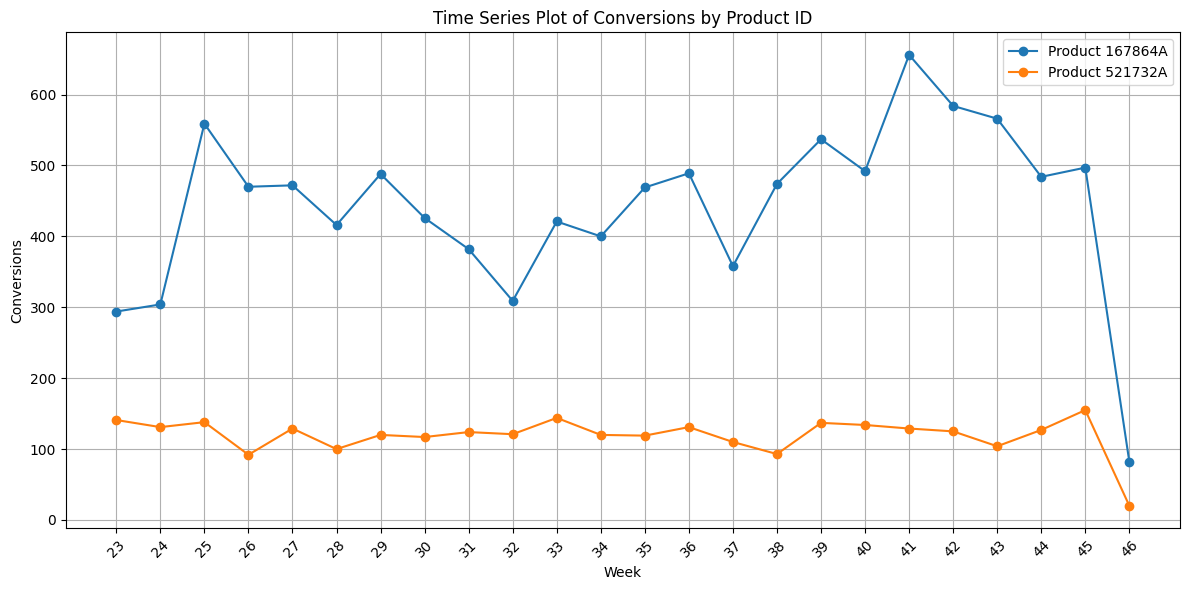

In [235]:
# Grouping by Week and product_id and summing Conversions
grouped_df = df.groupby(['Week', 'product_id']).sum().reset_index()

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each product's conversions separately
for product in grouped_df['product_id'].unique():
    product_df = grouped_df[grouped_df['product_id'] == product]
    plt.plot(product_df['Week'], product_df['Conversions'], marker='o', label=f'Product {product}')

plt.title('Time Series Plot of Conversions by Product ID')
plt.xlabel('Week')
plt.ylabel('Conversions')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

There has been a fairly stable volume of conversions for product 521732A (approximately 140 per week), but product 167864A seems to fluctuate a lot more - between 300 to 650

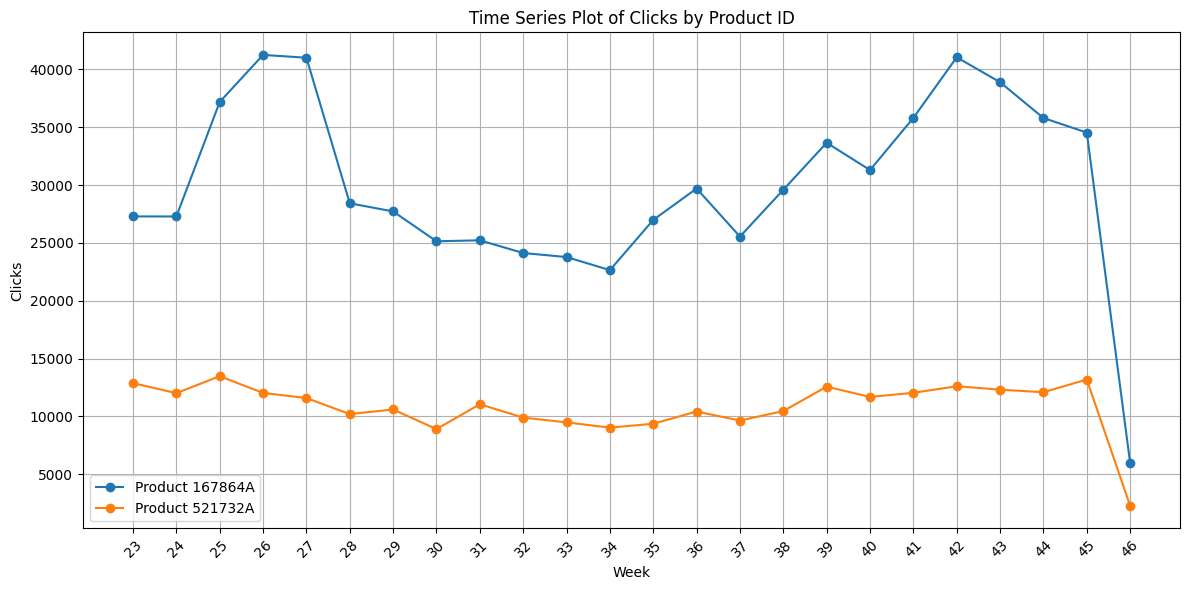

In [236]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each product's conversions separately
for product in grouped_df['product_id'].unique():
    product_df = grouped_df[grouped_df['product_id'] == product]
    plt.plot(product_df['Week'], product_df['nbr_clicks'], marker='o', label=f'Product {product}')

plt.title('Time Series Plot of Clicks by Product ID')
plt.xlabel('Week')
plt.ylabel('Clicks')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

The volume of clicks seems to also be stable for product 521732A, but for 167864A, there is a obvious correlation between the increase in clicks with the increase in conversions and viceversa

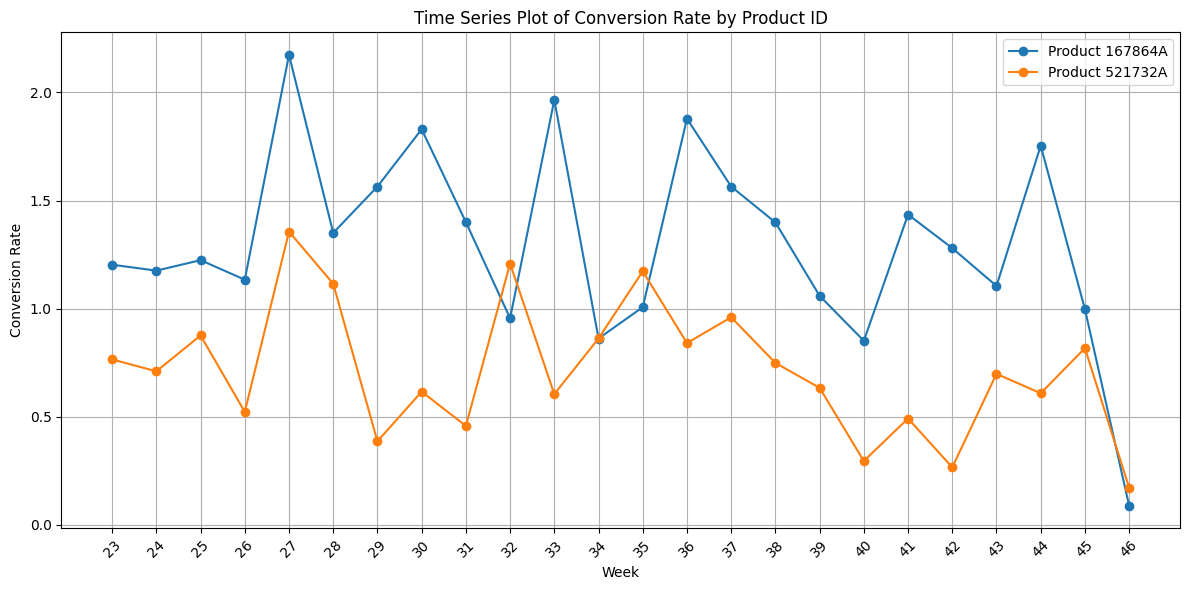

In [237]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each product's conversions separately
for product in grouped_df['product_id'].unique():
    product_df = grouped_df[grouped_df['product_id'] == product]
    plt.plot(product_df['Week'], product_df['cr'], marker='o', label=f'Product {product}')

plt.title('Time Series Plot of Conversion Rate by Product ID')
plt.xlabel('Week')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

Even though the volume of conversions and clicks was stable for 521732A, the conversion rate seems to have fluctuated a lot, just like 167864A. <br>

Most of the weeks there was an overlapping behaviour of CVR across the 2 products.
However, there were some moments like on week 32 where there was a huge increase in CVR for product 52 while there was a huge decrease for product 16. This behaviour was because the number of clicks decreased, but conversions remained the same.
On opposite directions, the same thing happened on week 33 - here the behaviour was that the volume of conversions increased a lot while clicks decreased a bit.

## Correlation

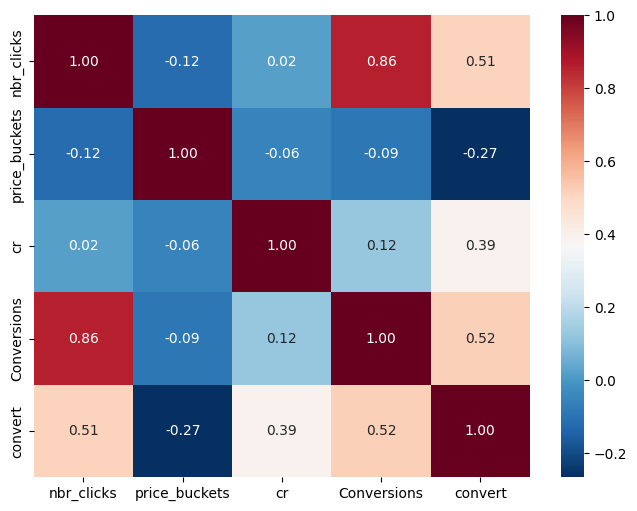

In [238]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu_r')

# Display the heatmap
plt.show()

There is no obvious impact of any variable on conversion rate

## Linear Regression

In [239]:
# Drop time variable - date and product_id because they can't go into the model and Conversions so it doesn't leak the model
cols_to_drop  = ['date', 'product_id', 'Conversions']
df.drop(columns=cols_to_drop,inplace=True)

In [240]:
#Copy of the dataframe for the algorithms with normalization need - Regressions
R = df.copy(deep=True)

In [241]:
# Associating the dataframe with the target variable
y = R['convert']

In [242]:
# Split into train and test (75% train and 25% test)
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.25, stratify=y, random_state=123)

In [243]:
# Remove the Target from the training
X_train = X_train.drop(['convert'],1)
X_test = X_test.drop(['convert'],1)

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/3950814221.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop(['convert'],1)
/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/3950814221.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = X_test.drop(['convert'],1)


In [244]:
# Dataframe for scaling
tempDF = df.copy(deep=True)
tempDF.drop(columns='convert', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [245]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

In [246]:
# Create and train the model  Linear regression 
lr_regr = linear_model.LinearRegression()
lr_regr.fit(X_train_scaled, y_train)

LinearRegression()

<module 'matplotlib.pyplot' from '/Users/diogodiogo/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

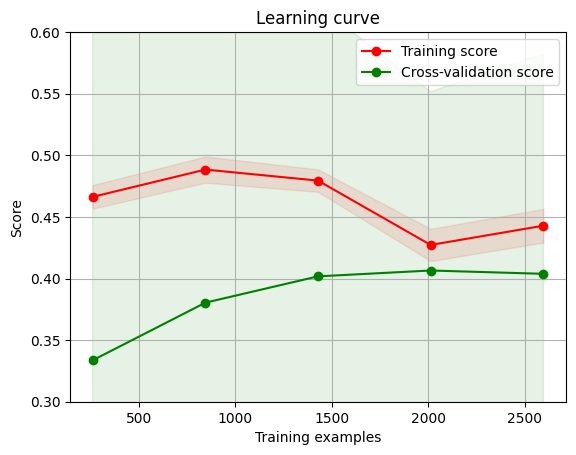

In [247]:
# Plot the learning curve

# Cross validation division of 5 or 10 folds
cv = 10
estimator = linear_model.LinearRegression()
plot_learning_curve(estimator, "Learning curve", X_train_scaled, y_train, ylim=(0.3, 0.6), cv=cv, n_jobs=4,
                   train_sizes=np.linspace(0.1, 1.0, 5))

With the increase of volume of data points, the training and cross-validation convert around 0.4-0.45

In [248]:
# Print the Intercept
print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(R.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 0.49706503800364377 



,Feature,Coefficient,AbsCoefficient
2,cr,5.234837,5.234837
0,nbr_clicks,1.963452,1.963452
1,price_buckets,-0.838417,0.838417
3,Week,-0.252781,0.252781
4,Month,0.170707,0.170707
5,Year,0.000000,0.000000


The CR and Number of Clicks seems to hold some explainability of the dependent variable

In [249]:
# predict y for X_train and X_test
y_pred_train = lr_regr.predict(X_train_scaled) 
y_pred_test = lr_regr.predict(X_test_scaled) 

In [250]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/4175523280.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/7g/q_2j27sx0031sv8_qdf0n5000000gn/T/ipykernel_6301/4175523280.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


,Measure,Train,Test
0,MAE,0.323498,0.322557
1,RMSE,0.372746,0.364061
2,R^2,0.441339,0.467017
3,MAPE (%),inf,inf
4,MAX Error,4.432447,1.964577


The models are not good enough to explain the behaviour of sales, as the R Squared is only 0.44. However, there seems to not be any kinda of overfitting as the R Squared is similar.

## How would I improve the data?

- Increase datapoints:
    - To better understand the effect of price on conversion rate, it would be interesting to:
        - Know what is the product category that we are looking into - maybe one can be a new device and the other an older device;
        - Add variables about which device was used to assess the data - desktop traditionally has higher CVR than mobile;
        - If it was a new or returning customer - returning customers will have totally different behaviour that might lead to higher CVR;
        - How did the user access the website (source medium) - if acccessing through Display/YouTube there will be a lower predisposition to convert than Brand Search;
        - Include price of competitors to see if any moment in time in which there was a decrease in CVR if there was a decrease in price of competitors;
        - Signal if there was any campaign ongoing;
- Improve the model:
        - Increase the volume of datapoints, especially because there's only 4k datapoints and by splitting 75/25, the volume of datapoints for each set is not much;